# Federal Reserve Minutes Sentiment Analysis 

The objective of this notebook is to extract topics and sentiment from Federal Minutes (2004-Present), leveraging natural language techniques such as bag of words and Latent Dirichlet Allocation (LDA). Sentiment is calculated using FinBert


# <a name="data-o"></a> Data Overview
Data was web scrapped using [Webscraper.py]from https://www.federalreserve.gov/monetarypolicy/fomccalendars.htm and saved in the directory below. 
The year 2004 was chosen as the start-year given the acceleration of release dates to 3 weeks, and improved clarity in explanations of committee’s decisions and views [(Danker,2005)](https://www.federalreserve.gov/pubs/bulletin/2005/spring05_fomc.pdf)

<br> 
In this section we will examine the transcripts' structure.

## <a name="sum"></a>Summary

In [155]:
pip_packages = [
    "charset-normalizer==2.0.10",
    "cycler==0.11.0",
    "filelock==3.4.2",
    "flake8==4.0.1",
    "fonttools==4.29.0",
    "funcy==1.17",
    "future==0.18.2",
    "gensim==4.1.2",
    "huggingface-hub==0.4.0",
    "idna==3.3",
    "jinja2==3.0.3",
    "joblib==1.1.0",
    "kiwisolver==1.3.2",
    "markupsafe==2.0.1",
    "matplotlib==3.5.1",
    "mccabe==0.6.1",
    "nltk==3.6.7",
    "numexpr==2.8.1",
    "numpy==1.22.1",
    "packaging==21.3",
    "pandas==1.4.0",
    "pep8==1.7.1",
    "pillow==9.0.0",
    "pycodestyle==2.8.0",
    "pyflakes==2.4.0",
    "pyldavis==3.3.1",
    "pyparsing==3.0.7",
    "pytz==2021.3",
    "pyyaml==6.0",
    "regex==2022.1.18",
    "requests==2.27.1",
    "sacremoses==0.0.47",
    "scikit-learn==1.0.2",
    "scipy==1.7.3",
    "seaborn==0.11.2",
    "sklearn==0.0",
    "smart-open==5.2.1",
    "threadpoolctl==3.0.0",
    "tokenizers==0.11.4",
    "torch==1.10.2",
    "tqdm==4.62.3",
    "transformers==4.16.1",
    "urllib3==1.26.8"
]

# Generate pip install commands
for package in pip_packages:
    print(f"pip install {package}")


pip install charset-normalizer==2.0.10
pip install cycler==0.11.0
pip install filelock==3.4.2
pip install flake8==4.0.1
pip install fonttools==4.29.0
pip install funcy==1.17
pip install future==0.18.2
pip install gensim==4.1.2
pip install huggingface-hub==0.4.0
pip install idna==3.3
pip install jinja2==3.0.3
pip install joblib==1.1.0
pip install kiwisolver==1.3.2
pip install markupsafe==2.0.1
pip install matplotlib==3.5.1
pip install mccabe==0.6.1
pip install nltk==3.6.7
pip install numexpr==2.8.1
pip install numpy==1.22.1
pip install packaging==21.3
pip install pandas==1.4.0
pip install pep8==1.7.1
pip install pillow==9.0.0
pip install pycodestyle==2.8.0
pip install pyflakes==2.4.0
pip install pyldavis==3.3.1
pip install pyparsing==3.0.7
pip install pytz==2021.3
pip install pyyaml==6.0
pip install regex==2022.1.18
pip install requests==2.27.1
pip install sacremoses==0.0.47
pip install scikit-learn==1.0.2
pip install scipy==1.7.3
pip install seaborn==0.11.2
pip install sklearn==0.0
pip

In [14]:
import os
import pandas as pd
import numpy as np 
import re
import string

from utils.corpusutils import CorpusPreProcess, Document, Corpus
from utils.featureutils import FeatureProcessor,find_closest


from nltk.tokenize import WordPunctTokenizer
from nltk.data import LazyLoader
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize.treebank import TreebankWordDetokenizer
from nltk.corpus import stopwords
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

from transformers import AutoTokenizer, AutoModelForSequenceClassification

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial.distance import jensenshannon
import torch
import joblib
import pickle
import pyLDAvis
import pyLDAvis.lda_model
pyLDAvis.enable_notebook()
import warnings
warnings.filterwarnings('ignore')

In [157]:

current_directory = os.getcwd()
root = os.path.join(current_directory,"Minutes")
word_tokenizer = WordPunctTokenizer()
sent_tokenizer = LazyLoader("tokenizers/punkt/english.pickle")
category_pattern = r'(\d{4})/*'
file_extension = r'*.txt'
file_pattern = r'(\d{8})/*'
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()
stop_words = stopwords.words('english') + list(string.punctuation) + ['u','.','s','--','-','."',',"','.)',')-','".','—','),'] 


fed_mins = CorpusPreProcess(root=root,file_extension = file_extension,
                            category_pattern=category_pattern,
                            file_pattern=file_pattern,
                            word_tokenizer = word_tokenizer,
                            sent_tokenizer=sent_tokenizer,
                            stemmer = stemmer,
                            lemmatizer = lemmatizer,
                            stop_words = stop_words
                            )

In [158]:
fed_mins_ids = fed_mins.get_file_ids()

print('Total number of files: '+str(len(fed_mins_ids)))
print('Number of paragraphs: '+str(len(fed_mins.get_paras())))
print('Number of sentences: '+str(len(fed_mins.get_sents())))
print('Number of words: '+str(len(fed_mins.get_words())))
print('\n'+'First file: '+ fed_mins_ids[0])
print('Last file: '+ fed_mins_ids[-1])

Total number of files: 163
Number of paragraphs: 18318
Number of sentences: 49832
Number of words: 1383245

First file: 20040128
Last file: 20240612


In [159]:
#For each Category
para_by_year = {}

for cat in fed_mins.get_category_ids():
    files = fed_mins.get_file_ids(category_id=cat)
    para_by_year[cat] = {'nparas':sum(len(fed_mins.get_paras(file_id=f)) for f in files)/len(files),
                        'nwords':sum(len(fed_mins.get_words(file_id=f)) for f in files)/len(files)}


<Axes: title={'center': 'Paragraphs and words overtime'}>

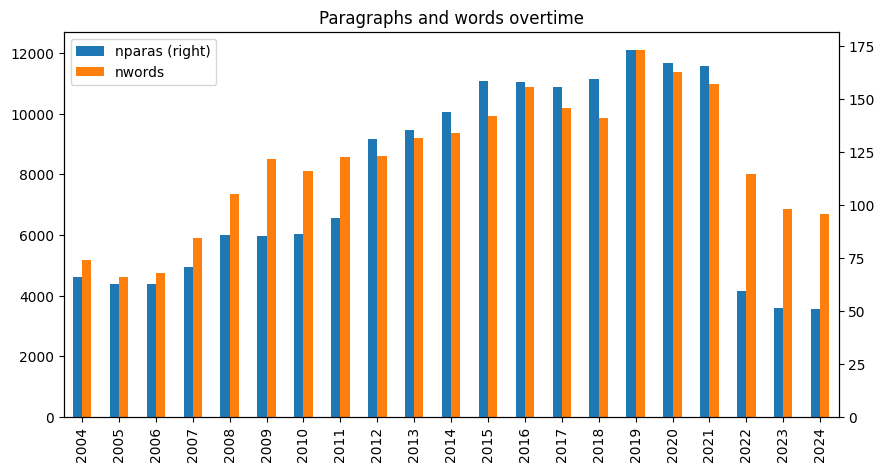

In [160]:
pd.DataFrame.from_dict(para_by_year).T.sort_index().plot(kind='bar',secondary_y='nparas',figsize=(10,5),title='Paragraphs and words overtime')


We can see an acceleration in the amount of paragraphs and words overtime.

In [161]:
start_regex = r"""(?i)(staff\sreview\sof\sthe\seconomic|the\sinformation\s[\s]?(?:reviewed|received|provided)|the\scommittee\sthen\sturned\sto\sa\sdiscussion\sof\sthe\seconomic\soutlook|in\sthe\scommittee[\']?s\sdiscussion\sof\scurrent\sand\sprospective\seconomic)"""
end_regex = r"""(?i)(at\sthe\sconclusion\sof\s[\s]?(?:the|this)\s(?:discussion|meetings)|the\scommitte\svoted\sto\sauthorize|the\svote\sencompassed\sapproval\sof)"""
file_stats = fed_mins.truncate_text(start_regex,end_regex,return_stats=True)

Overwritting existing folder
end_regex could not be found in 20220504.txt, defaulting to end of file


In [162]:
pd.Series(file_stats).rename('size_pct_change').to_frame().sort_values(by='size_pct_change')

,size_pct_change
20200129.txt,-60.414296
20190130.txt,-59.268669
20180131.txt,-58.432987
20140129.txt,-57.307791
20050202.txt,-56.184258
...,...
20221102.txt,-12.150198
20230322.txt,-10.266734
20221214.txt,-10.254278
20230201.txt,-9.318664


# Further pre-processing

In [163]:
file_example = '20171213'
sent_example = fed_mins.get_sents(file_id=file_example,stem=True,lemmatize=True)[32]
print('\033[1m'+"Example Sentence"+'\033[0m')
print(TreebankWordDetokenizer().detokenize(sent_example))

print('\n'+'\033[1m'+"Tokenize"+'\033[0m')
print(sent_example)

print('\n'+'\033[1m'+"Stem tokens"+'\033[0m')
sent_stemmed = sent_example.stem
print(sent_stemmed)

print('\n'+'\033[1m'+"Lemmatize tokens"+'\033[0m')
sent_lemmatized = sent_example.lemma
print(sent_lemmatized)

Example Sentence
Total U . S . consumer prices, as measured by the PCE price index, increased slightly more than 1 - 1 / 2 percent over the 12 months ending in October.

Tokenize
['Total', 'U', '.', 'S', '.', 'consumer', 'prices', ',', 'as', 'measured', 'by', 'the', 'PCE', 'price', 'index', ',', 'increased', 'slightly', 'more', 'than', '1', '-', '1', '/', '2', 'percent', 'over', 'the', '12', 'months', 'ending', 'in', 'October', '.']

Stem tokens
['total', 'consum', 'price', 'measur', 'pce', 'price', 'index', 'increas', 'slightli', 'percent', 'month', 'end', 'octob']

Lemmatize tokens
['total', 'consumer', 'price', 'measure', 'pce', 'price', 'index', 'increase', 'slightly', 'percent', 'month', 'end', 'october']


# LDA

In [164]:
import os
import re
import string
import shutil
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from nltk.tokenize import WordPunctTokenizer
from nltk.data import LazyLoader
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

# Define directories
combined_dir = "Minutes_truncated"

# Preprocess the combined texts
stop_words = set(stopwords.words('english')) | {'u', 's', '--', '-', '."', ',"', '.)', ')-', '".', '—', '),'}
lemmatizer = WordNetLemmatizer()

# Preprocess and vectorize texts
def preprocess_text(text):
    tokens = word_tokenize(text.lower())
    tokens = [t for t in tokens if t not in stop_words and t.isalpha()]  # Remove stopwords and non-alphabetic tokens
    tokens = [lemmatizer.lemmatize(t) for t in tokens]
    return ' '.join(tokens)

texts = []
for file in os.listdir(root):
    if file.endswith(".txt"):
        with open(os.path.join(root, file), 'r', encoding='utf-8') as f:
            text = f.read()
            preprocessed_text = preprocess_text(text)
            texts.append(preprocessed_text)

# Ensure all elements in texts are strings
texts = [str(text) for text in texts if isinstance(text, str)]



In [165]:
print(f"Sample preprocessed text:\n{texts[0]}")

Sample preprocessed text:
meeting federal open market committee held office board governor federal reserve system washington wednesday november moskow santomero stern alternate member federal open market committee guynn lacker yellen president federal reserve bank atlanta richmond san francisco respectively connors fuhrer hakkio howard madigan slifman sniderman rasche wilcox associate economist ko manager system open market account ettin deputy director division research statistic board governor oliner struckmeyer associate director division research statistic board governor clouse whitesell deputy associate director division monetary affair board governor english assistant director division monetary affair board governor simpson senior adviser division research statistic board governor brady section chief division monetary affair board governor small project manager division monetary affair board governor skidmore special assistant board office board member board governor luecke senio

We want a balance between the # of topics, and how different everything is.

In [166]:
import joblib
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA

# Assuming the vectorizer and LDA model are already defined as per your script
# Vectorizer and model fitting

paras = fed_mins.get_paras(flatten=True,stem=True)
def return_self(x):return x

vectorizer = CountVectorizer(tokenizer=return_self, lowercase=False, preprocessor=return_self)
bag_of_words = vectorizer.fit_transform((doc.stem for doc in paras))

num_topics_6 = 6
lda_model_6 = LDA(n_components=num_topics_6, max_iter=20, learning_method='online', random_state=10, n_jobs=-1)
lda_transform_6 = lda_model_6.fit_transform(bag_of_words)

# Function to summarize topics
def summarize_topics(model, feature_names, no_top_words):
    topics = pd.DataFrame()
    for topic_idx, topic in enumerate(model.components_):
        top_words = [feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]
        topics["Topic %d:" % (topic_idx)] = top_words
    return topics

topics_6 = summarize_topics(lda_model_6, vectorizer.get_feature_names_out(), 10)
print("Topics for 6 topics:")
print(topics_6)

# Save the model and vectorizer as .pkl files
joblib_file_lda = "lda_model_6_topics.pkl"
joblib_file_vectorizer = "count_vectorizer.pkl"
joblib.dump(lda_model_6, joblib_file_lda)
joblib.dump(vectorizer, joblib_file_vectorizer)

print(f"LDA model with 6 topics saved as {joblib_file_lda}")
print(f"CountVectorizer saved as {joblib_file_vectorizer}")


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable To disable this warning, you can either:
TOKENIZERS_PARALLELISM=(true | false)
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Topics for 6 topics:
   Topic 0:  Topic 1: Topic 2: Topic 3:  Topic 4:   Topic 5:
0  particip   quarter   credit   inflat  particip     period
1    inflat      rate     loan    price    growth     market
2  committe   increas   remain   expect      busi    foreign
3    polici     month     bank   consum     spend      yield
4      rate   product   market     year     activ      price
5     would    declin     rate    staff     price  intermeet
6    econom    employ  mortgag   measur    econom    economi
7     feder     labor  continu  project   continu     econom
8      risk  unemploy   condit     real    recent     declin
9    member     level  issuanc   growth    consum     dollar
LDA model with 6 topics saved as lda_model_6_topics.pkl
CountVectorizer saved as count_vectorizer.pkl


In [167]:
## What are the most frequently used words
term_counts = {i:j for i, j in zip(vectorizer.get_feature_names_out(), bag_of_words.toarray().sum(axis=0))}
df_term_counts = pd.DataFrame(sorted(term_counts.items(), key=lambda x: x[1], reverse=True), columns=['term', 'count'])
df_term_counts.head(5)


,term,count
0,inflat,8900
1,rate,8118
2,price,7188
3,market,7026
4,particip,6942


In [168]:
df_results = summarize_topics(lda_model_6, vectorizer.get_feature_names_out(), 10)
df_results


,Topic 0:,Topic 1:,Topic 2:,Topic 3:,Topic 4:,Topic 5:
0,particip,quarter,credit,inflat,particip,period
1,inflat,rate,loan,price,growth,market
2,committe,increas,remain,expect,busi,foreign
3,polici,month,bank,consum,spend,yield
4,rate,product,market,year,activ,price
5,would,declin,rate,staff,price,intermeet
6,econom,employ,mortgag,measur,econom,economi
7,feder,labor,continu,project,continu,econom
8,risk,unemploy,condit,real,recent,declin
9,member,level,issuanc,growth,consum,dollar


In [172]:
pyLDAvis.lda_model.prepare(lda_model_6,bag_of_words,vectorizer)



huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

In [39]:
# Prepare the visualization
lda_vis = pyLDAvis.lda_model.prepare(lda_model_6, bag_of_words, vectorizer)

# Save the visualization to an HTML file
pyLDAvis.save_html(lda_vis, 'lda_vis.html')

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)



[notice] A new release of pip is available: 24.0 -> 24.1.2
[notice] To update, run: pip install --upgrade pip


In [113]:
topic_dict = {
    0: "Inflation and Prices",
    1: "Economic Growth and Business Activity",
    2: "Quarterly Economic Performance",
    3: "Committee Deliberations and Policies",
    4: "Credit Markets and Financial Conditions",
    5: "Economic Forecasts and Projections"
}


Topic: Inflation and Prices​

Relevant Terms: "inflat," "price," "labor," "month," "rate," "measur," "percent," "remain," "increas."​

These terms directly relate to discussions on inflation, price levels, labor market conditions, and related measurements.​

Topic: Economic Growth and Business Activity​

Relevant Terms: "growth," "econom," "project," "year," "quarter."​

These terms focus on overall economic growth, projections, and business activities.​

Topic: Quarterly Economic Performance​

Relevant Terms: "quarter," "loan," "increas," "real," "remain," "declin," "continu," "credit," "sale," "consum."​

These terms are aligned with economic performance on a quarterly basis, including credit activities and consumer behavior.​

Topic: Committee Deliberations and Policies​

Relevant Terms: "committe," "particip," "polici," "would," "econom," "member," "rate," "feder," "risk."​

These terms relate to discussions and policy decisions made by the committee.​

Topic: Credit Markets and Financial Conditions​

Relevant Terms: "market," "period," "rate," "yield," "intermeet," "bank," "financi," "treasuri," "fund," "secur."​

These terms are associated with market conditions, financial stability, and credit markets.​

Topic: Economic Forecasts and Projections​

Relevant Terms: "particip," "busi," "spend," "price," "growth," "note," "continu," "recent," "sector," "market."​

These terms relate to forecasts and projections about the economy, including business activities and consumer spending.​

​

## <a name="finbert"></a>FinBERT
FinBERT is a pre-trained transformer model, specifically trained for the finance domain. https://github.com/ProsusAI/finBERT. The sentiment scoring component derives from Financial PhraseBank dataset. 
Here we will score each old text instead of our lemmatised 'new text'. 

Most documents have tokens less than the maximum model size, which means we don't have to worry about truncation, in fact we could probably truncate our tokens to 350

In [141]:
import joblib
import pandas as pd

# Load the LDA model and the vectorizer
lda_model = joblib.load('lda_model_6_topics.pkl')
vectorizer = joblib.load('count_vectorizer.pkl')

# Function to summarize topics
def summarize_topics(model, feature_names, no_top_words):
    topics = pd.DataFrame()
    for topic_idx, topic in enumerate(model.components_):
        top_words = [feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]
        topics["Topic %d:" % (topic_idx)] = top_words
    return topics

# Summarize topics with the top 10 words
topics = summarize_topics(lda_model, vectorizer.get_feature_names_out(), 10)
print("Topics and their top words:")
print(topics)


Topics and their top words:
  Topic 0:  Topic 1: Topic 2:  Topic 3:   Topic 4:  Topic 5:
0  quarter    inflat   inflat    growth     market  particip
1     loan  committe    price    econom     period      busi
2  increas  particip    labor   project       rate     spend
3     real    polici    month      year      yield     price
4   remain     would     rate     staff  intermeet    growth
5   declin    econom   measur   quarter       bank      note
6  continu    member  percent   economi    financi   continu
7   credit      rate     year      rate   treasuri    recent
8     sale     feder  increas  forecast       fund    sector
9   consum      risk   remain       gdp      secur    market


In [142]:
# Renaming topics
topic_dict = {
    0: "Quarterly Economic Performance",
    1: "Committee Deliberations and Policies",
    2: "Inflation and Prices",
    3: "Economic Growth and Business Activity",
    4: "Credit Markets and Financial Conditions",
    5: "Economic Forecasts and Projections"
}

print("Renamed topics:")
for key, value in topic_dict.items():
    print(f"Topic {key}: {value}")


Renamed topics:
Topic 0: Quarterly Economic Performance
Topic 1: Committee Deliberations and Policies
Topic 2: Inflation and Prices
Topic 3: Economic Growth and Business Activity
Topic 4: Credit Markets and Financial Conditions
Topic 5: Economic Forecasts and Projections


## for all

In [133]:
#Load tokenizer and model
transformer_tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
transformer_model = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert",output_hidden_states=True,output_attentions=False)
 

In [134]:
text = ['Participants','remarked','that','inflation','readings','had','been','higher','and','were','more','persistent','and','widespread','than','previously','anticipated','.']

In [135]:
print(transformer_tokenizer.convert_ids_to_tokens(transformer_tokenizer(paras[0].tokens,padding=True,is_split_into_words=True)['input_ids']))

Token indices sequence length is longer than the specified maximum sequence length for this model (596 > 512). Running this sequence through the model will result in indexing errors


['[CLS]', 'at', 'this', 'meeting', 'suggests', 'that', 'the', 'economy', 'has', 'been', 'growing', 'rather', 'slowly', 'in', 'recent', 'months', '.', 'non', '##far', '##m', 'payroll', 'employment', 'continued', 'to', 'expand', 'moderately', 'in', 'december', ',', 'and', 'the', 'civilian', 'unemployment', 'rate', 'remained', 'at', '5', '.', '6', 'percent', '.', 'industrial', 'production', 'increased', 'only', 'slightly', 'further', 'in', 'the', 'fourth', 'quarter', '.', 'growth', 'of', 'consumer', 'spending', 'was', 'modest', ',', 'on', 'balance', ',', 'over', 'the', 'past', 'several', 'months', '.', 'housing', 'starts', 'rebound', '##ed', 'in', 'november', 'from', 'a', 'sizable', 'october', 'decline', '.', 'orders', 'for', 'non', '##de', '##fen', '##se', 'capital', 'goods', 'point', 'to', 'a', 'mode', '##ration', 'in', 'the', 'expansion', 'of', 'spending', 'on', 'business', 'equipment', ',', 'and', 'non', '##res', '##ide', '##ntial', 'construction', 'has', 'risen', 'app', '##re', '##ci

In [136]:
#How many our of documents get truncated?
plengths = []
for p in paras:
    plengths.append(len(transformer_tokenizer.encode(p.tokens,padding=True,is_split_into_words=True)))

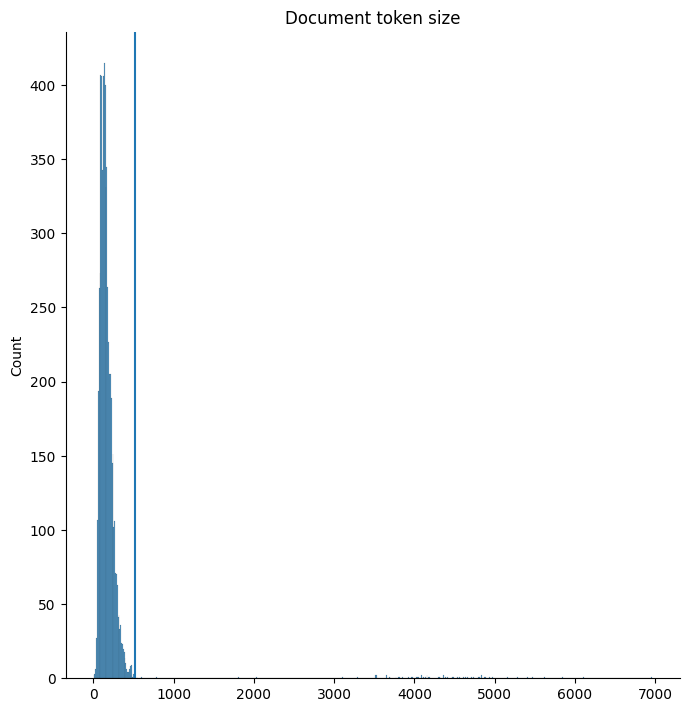

In [137]:

sns.displot(plengths,height=7).set(title='Document token size')
plt.axvline(transformer_tokenizer.model_max_length)

In [143]:
file_id = '20211215'
latest_minutes = fed_mins.get_paras(file_id = file_id,flatten=True,stem=True)
tokenizer_settings = dict(is_split_into_words=True,max_length=350,padding='max_length',truncation=True,return_tensors="pt")

document_feat = FeatureProcessor(latest_minutes,
                                transformer_model=transformer_model,
                                transformer_tokenizer=transformer_tokenizer,
                                tokenizer_settings=tokenizer_settings,
                                lda_model=lda_model,
                                lda_vec=vectorizer,
                                lda_topic_dict=topic_dict,batch_size=30)

In [144]:
latest_minutes = document_feat.get_features(sentiment=True,embedding=True,topic=True)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

In [145]:
def corpus_stats(corpus):
    ids = [(n,f.category_id,f.file_id) for n,f in enumerate(corpus)]
    df_ids = pd.DataFrame(ids,columns=['idx','category_id','file_id'])
    start_idx = df_ids.drop_duplicates(['category_id','file_id'],keep='first')
    end_idx = df_ids.drop_duplicates(['category_id','file_id'],keep='last')

    idx = start_idx.merge(end_idx,on=['category_id','file_id'],suffixes=('_start','_end'))

    stats =[]
    corpus_sent = corpus.extract_features('sentiment')
    corpus_topic = corpus.extract_features('topics')

    for s,cat_id,file_id,e in idx.values:
        net_tone = [s['logits'][0] - s['logits'][1] for s in corpus_sent[s:e]]
        topic_dist = [s['topic_dist'] for s in corpus_topic[s:e]]
        topic_sentiment = np.asarray(topic_dist) * np.asarray(net_tone).reshape(-1,1)
        topic_mean_sent = topic_sentiment.mean(axis=0).tolist()

        stats.append((cat_id,file_id,*topic_mean_sent))
    return stats


latest_stats = corpus_stats(latest_minutes)
latest_stats = pd.DataFrame(latest_stats,columns = ['category_id','file_id']+list(topic_dict.values()))
latest_stats['month'] = pd.to_datetime(latest_stats['file_id']).dt.to_period('M')
latest_stats.set_index(['month'],inplace=True)

<Axes: title={'center': 'Average net-tone per topic for file:20211215'}, xlabel='month'>

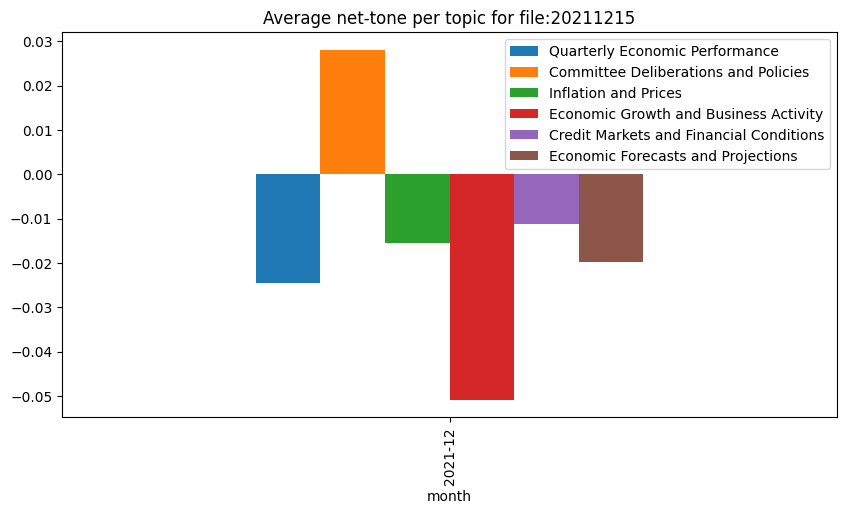

In [146]:
latest_stats.plot(kind='bar',title='Average net-tone per topic for file:{}'.format(file_id),figsize=(10,5))

<Axes: title={'center': 'Average net-tone per topic for file:20211215'}, xlabel='month'>

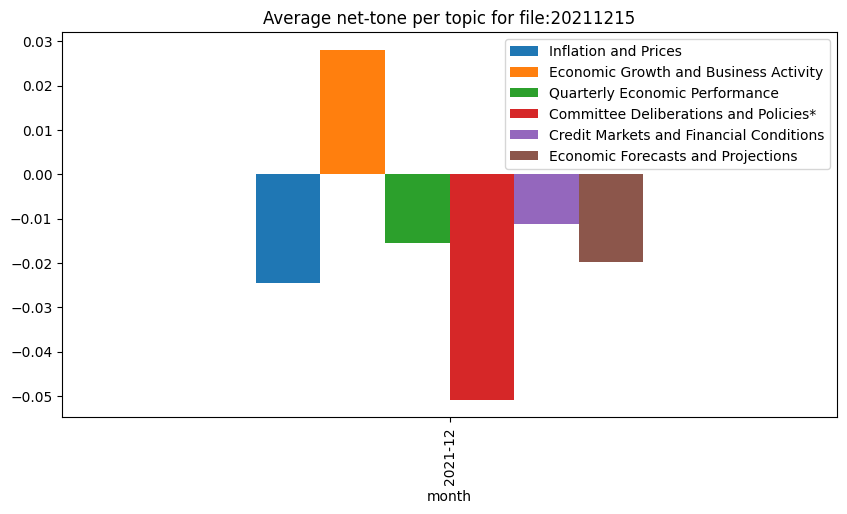

In [76]:
ORIGINAL SO I DONT FORGET

  0%|          | 0/21 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
TOKENIZERS_PARALLELISM=(true | false)
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
  5%|▍         | 1/21 [05:02<1:40:40, 302.03s/it]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the 

<Figure size 640x480 with 0 Axes>

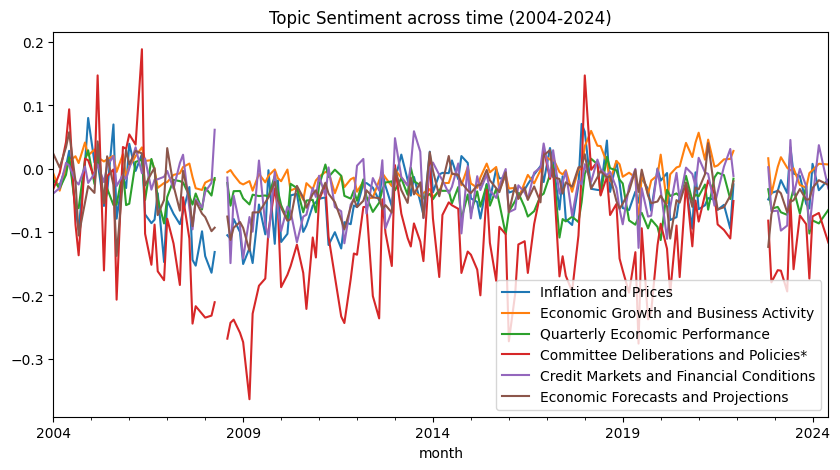

In [77]:
# Initialize an empty DataFrame for cumulative results
cumulative_stats = pd.DataFrame()

# Process data for each year from 2004 to 2024
for year in tqdm(range(2004, 2025)):
    last_year_minutes = fed_mins.get_paras(category_id=str(year), flatten=True, stem=True)

    document_feat = FeatureProcessor(
        last_year_minutes,
        transformer_model=transformer_model,
        transformer_tokenizer=transformer_tokenizer,
        tokenizer_settings=tokenizer_settings,
        lda_model=lda_model_6,
        lda_vec=vectorizer,
        lda_topic_dict=topic_dict,
        batch_size=30
    )
    last_year_minutes = document_feat.get_features()

    year_stats = pd.DataFrame(corpus_stats(last_year_minutes), columns=['category_id', 'file_id'] + list(topic_dict.values()))
    year_stats['month'] = pd.to_datetime(year_stats['file_id']).dt.to_period('M')
    year_stats.set_index(['month'], inplace=True)
    
    # Append to the cumulative DataFrame
    cumulative_stats = pd.concat([cumulative_stats, year_stats])

# Save the cumulative stats to a CSV file
cumulative_stats.to_csv('2004-2024-sentiment-by-topic.csv')

# Plot and save the cumulative figure
plt.figure()
cumulative_stats[[i for i in cumulative_stats.columns if i not in ['category_id', 'file_id']]].plot(
    kind='line', figsize=(10, 5), title='Topic Sentiment across time (2004-2024)')
plt.savefig('sentiment_plot_2004-2024.png')

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

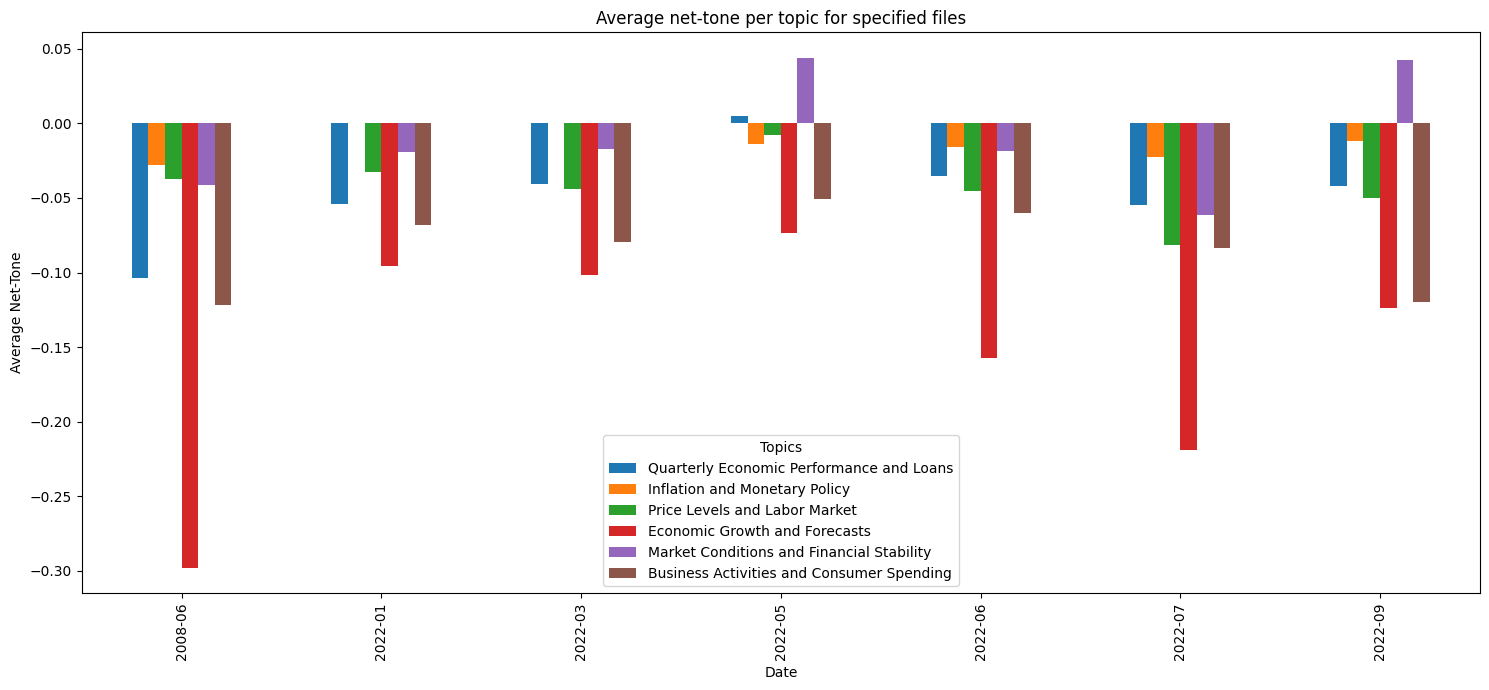

In [94]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

specific_dates = ['20080625', '20220126', '20220316', '20220504', '20220615', '20220727', '20220921']

# Function to extract features and compute statistics
def process_and_get_stats(file_id):
    latest_minutes = fed_mins.get_paras(file_id=file_id, flatten=True, stem=True)
    tokenizer_settings = dict(is_split_into_words=True, max_length=350, padding='max_length', truncation=True, return_tensors="pt")
    
    document_feat = FeatureProcessor(latest_minutes,
                                     transformer_model=transformer_model,
                                     transformer_tokenizer=transformer_tokenizer,
                                     tokenizer_settings=tokenizer_settings,
                                     lda_model=lda_model_6,
                                     lda_vec=vectorizer,
                                     lda_topic_dict=topic_dict,
                                     batch_size=30)
    
    latest_minutes = document_feat.get_features(sentiment=True, embedding=True, topic=True)
    
    def corpus_stats(corpus):
        ids = [(n, f.category_id, f.file_id) for n, f in enumerate(corpus)]
        df_ids = pd.DataFrame(ids, columns=['idx', 'category_id', 'file_id'])
        start_idx = df_ids.drop_duplicates(['category_id', 'file_id'], keep='first')
        end_idx = df_ids.drop_duplicates(['category_id', 'file_id'], keep='last')
    
        idx = start_idx.merge(end_idx, on=['category_id', 'file_id'], suffixes=('_start', '_end'))
    
        stats = []
        corpus_sent = corpus.extract_features('sentiment')
        corpus_topic = corpus.extract_features('topics')
    
        for s, cat_id, file_id, e in idx.values:
            net_tone = [s['logits'][0] - s['logits'][1] for s in corpus_sent[s:e]]
            topic_dist = [s['topic_dist'] for s in corpus_topic[s:e]]
            topic_sentiment = np.asarray(topic_dist) * np.asarray(net_tone).reshape(-1, 1)
            topic_mean_sent = topic_sentiment.mean(axis=0).tolist()
    
            stats.append((cat_id, file_id, *topic_mean_sent))
        return stats
    
    latest_stats = corpus_stats(latest_minutes)
    return latest_stats

# Collect statistics for all specific dates
all_stats = []

for date in specific_dates:
    stats = process_and_get_stats(date)
    all_stats.extend(stats)

# Create a DataFrame for the combined statistics
all_stats_df = pd.DataFrame(all_stats, columns=['category_id', 'file_id'] + list(topic_dict.values()))
all_stats_df['month'] = pd.to_datetime(all_stats_df['file_id']).dt.to_period('M')
all_stats_df.set_index(['month'], inplace=True)

# Plot the results
all_stats_df.plot(kind='bar', title='Average net-tone per topic for specified files', figsize=(15, 7))
plt.ylabel('Average Net-Tone')
plt.xlabel('Date')
plt.legend(title='Topics')
plt.tight_layout()
plt.show()


In [95]:
# Save the DataFrame to a CSV file
all_stats_df.to_csv('fed_minutes_stats.csv')

### Mediator/Moderator Analysis ish

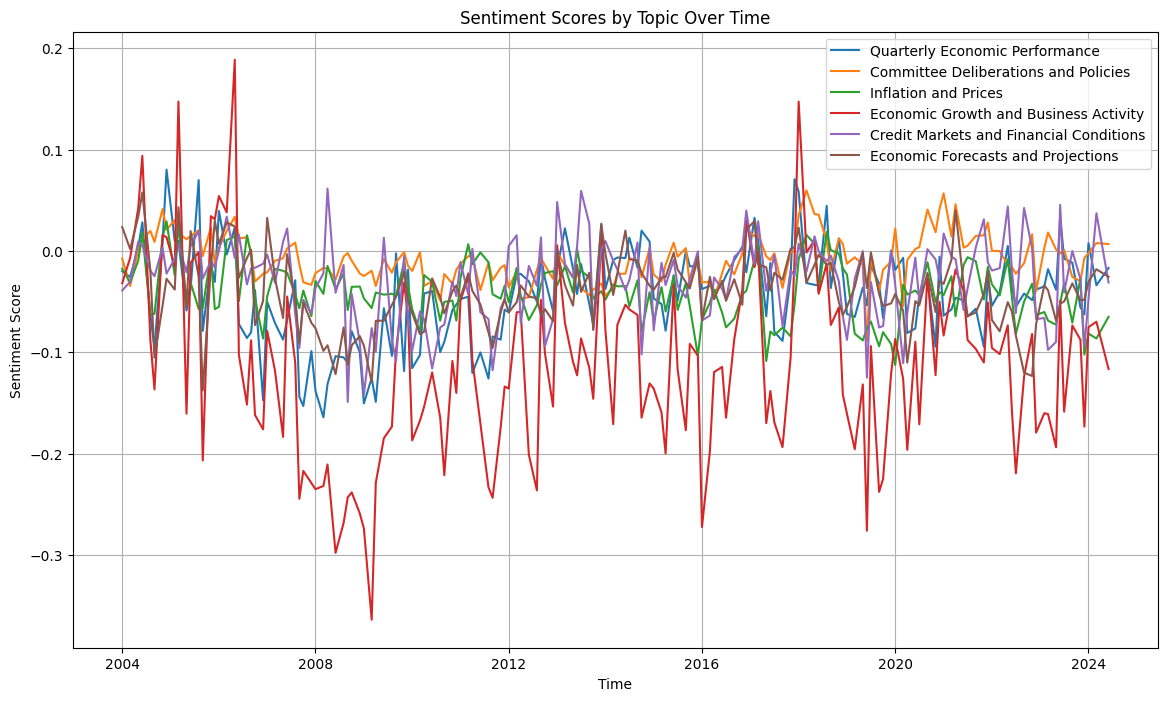

In [152]:
import pandas as pd

# Load the CSV file
file_path = 'Final Sentiment by Topic.csv'
sentiment_data = pd.read_csv(file_path)

# Display the first few rows of the dataframe to understand its structure
sentiment_data.head()
import matplotlib.pyplot as plt

# Set the 'month' column as the index for time series plotting
sentiment_data['month'] = pd.to_datetime(sentiment_data['month'])
sentiment_data.set_index('month', inplace=True)

# Plotting the sentiment scores for each topic
plt.figure(figsize=(14, 8))

for column in sentiment_data.columns[2:]:
    plt.plot(sentiment_data.index, sentiment_data[column], label=column)

plt.title('Sentiment Scores by Topic Over Time')
plt.xlabel('Time')
plt.ylabel('Sentiment Score')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()


In [150]:
import pandas as pd

# Load the data from the CSV file
file_path = 'vix_data.csv'
vix_data = pd.read_csv(file_path)

# Display the first few rows of the dataset
initial_overview = vix_data.head()

# Display the data types of each column
data_types = vix_data.dtypes

# Basic statistics of the dataset
basic_stats = vix_data.describe()

# Check for missing values
missing_values = vix_data.isnull().sum()

initial_overview, data_types, basic_stats, missing_values

(     DATE  CLOSE
 0  1/2/90  17.24
 1  1/3/90  18.19
 2  1/4/90  19.22
 3  1/5/90  20.11
 4  1/8/90  20.26,
 DATE      object
 CLOSE    float64
 dtype: object,
              CLOSE
 count  8712.000000
 mean     19.489907
 std       7.879884
 min       9.140000
 25%      13.790000
 50%      17.630000
 75%      22.870000
 max      82.690000,
 DATE     0
 CLOSE    0
 dtype: int64)

,month,category_id,date,Quarterly Economic Performance,Committee Deliberations and Policies,Inflation and Prices,Economic Growth and Business Activity,Credit Markets and Financial Conditions,Economic Forecasts and Projections,VIX
0,2004-01,2004,2004-01-28,-0.020010,-0.007505,-0.017354,-0.031805,-0.038883,0.023615,16.78
1,2004-03,2004,2004-03-16,-0.025546,-0.034595,-0.031002,-0.006696,-0.030285,0.001927,20.34
2,2004-05,2004,2004-05-04,0.003174,0.001184,-0.009438,0.042299,0.009341,0.033944,16.55
3,2004-06,2004,2004-06-30,0.028335,0.011751,0.017961,0.093891,0.005207,0.057718,14.34
4,2004-08,2004,2004-08-10,-0.063445,0.019796,-0.062641,-0.088112,-0.019402,-0.019696,17.47
...,...,...,...,...,...,...,...,...,...,...
158,2023-11,2023,2023-11-01,-0.055416,-0.029675,-0.027145,-0.087489,-0.027491,-0.048682,16.87
159,2023-12,2023,2023-12-13,-0.062617,-0.006863,-0.102174,-0.173305,-0.094937,-0.048179,12.19
160,2024-01,2024,2024-01-31,0.007811,-0.002197,-0.081461,-0.075116,-0.048020,-0.030250,14.35
161,2024-03,2024,2024-03-20,-0.033824,0.007917,-0.086288,-0.069736,0.037284,-0.018002,13.04


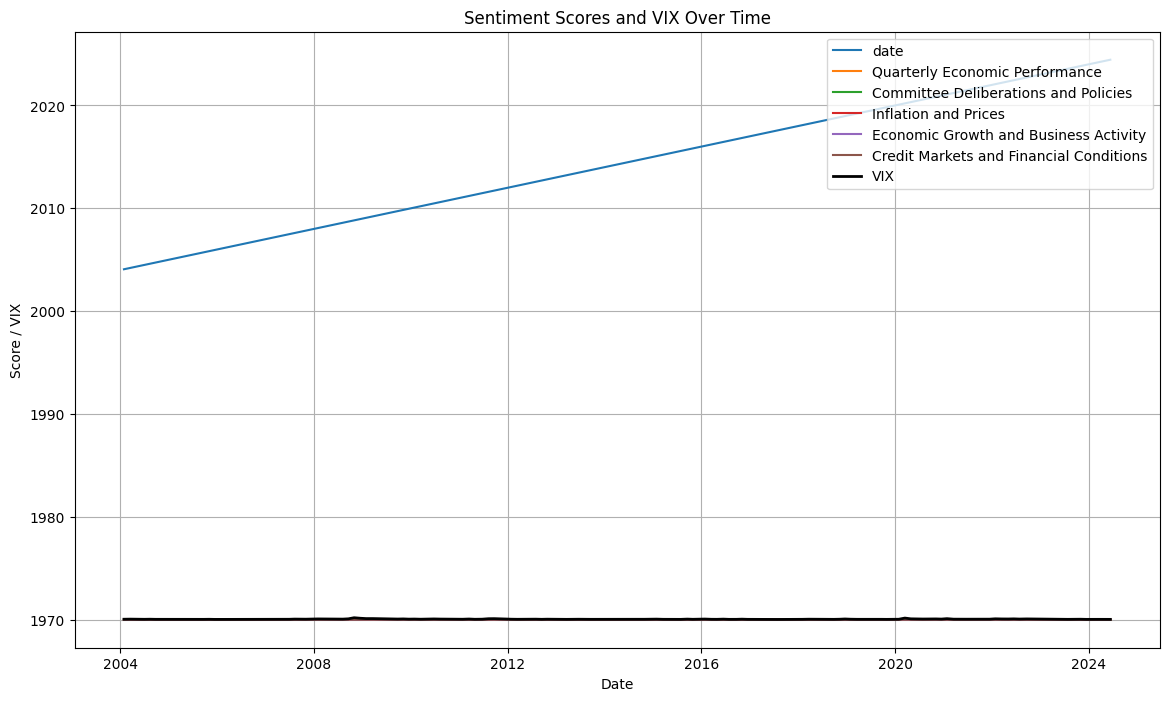

In [151]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the sentiment data
sentiment_file_path = 'Final Sentiment by Topic.csv'
sentiment_data = pd.read_csv(sentiment_file_path)

# Convert 'file_id' to datetime format
sentiment_data['file_id'] = pd.to_datetime(sentiment_data['file_id'], format='%Y%m%d')
sentiment_data.rename(columns={'file_id': 'date'}, inplace=True)

# Load the VIX data
vix_file_path = 'vix_data.csv'
vix_data = pd.read_csv(vix_file_path)

# Convert the DATE column to datetime format
vix_data['DATE'] = pd.to_datetime(vix_data['DATE'], format='%m/%d/%y')

# Rename columns to make merging clearer
vix_data.rename(columns={'DATE': 'date', 'CLOSE': 'VIX'}, inplace=True)

# Merge the sentiment data with VIX data using the closest date
merged_data = pd.merge_asof(sentiment_data.sort_values('date'), vix_data.sort_values('date'), on='date', direction='backward')

# Display the merged data
display(merged_data)

# Plotting the merged data
plt.figure(figsize=(14, 8))

for column in sentiment_data.columns[2:-1]:  # Exclude 'category_id' and 'date' columns
    plt.plot(merged_data['date'], merged_data[column], label=column)

plt.plot(merged_data['date'], merged_data['VIX'], label='VIX', color='black', linewidth=2)

plt.title('Sentiment Scores and VIX Over Time')
plt.xlabel('Date')
plt.ylabel('Score / VIX')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

# Save the merged data to a CSV file if needed
merged_data.to_csv('Merged_Sentiment_VIX_Data.csv', index=False)


plot the time series data, perform the ADF test, compute first differences for non-stationary variables, and plot the ACF. Finally, it will perform Granger causality tests:

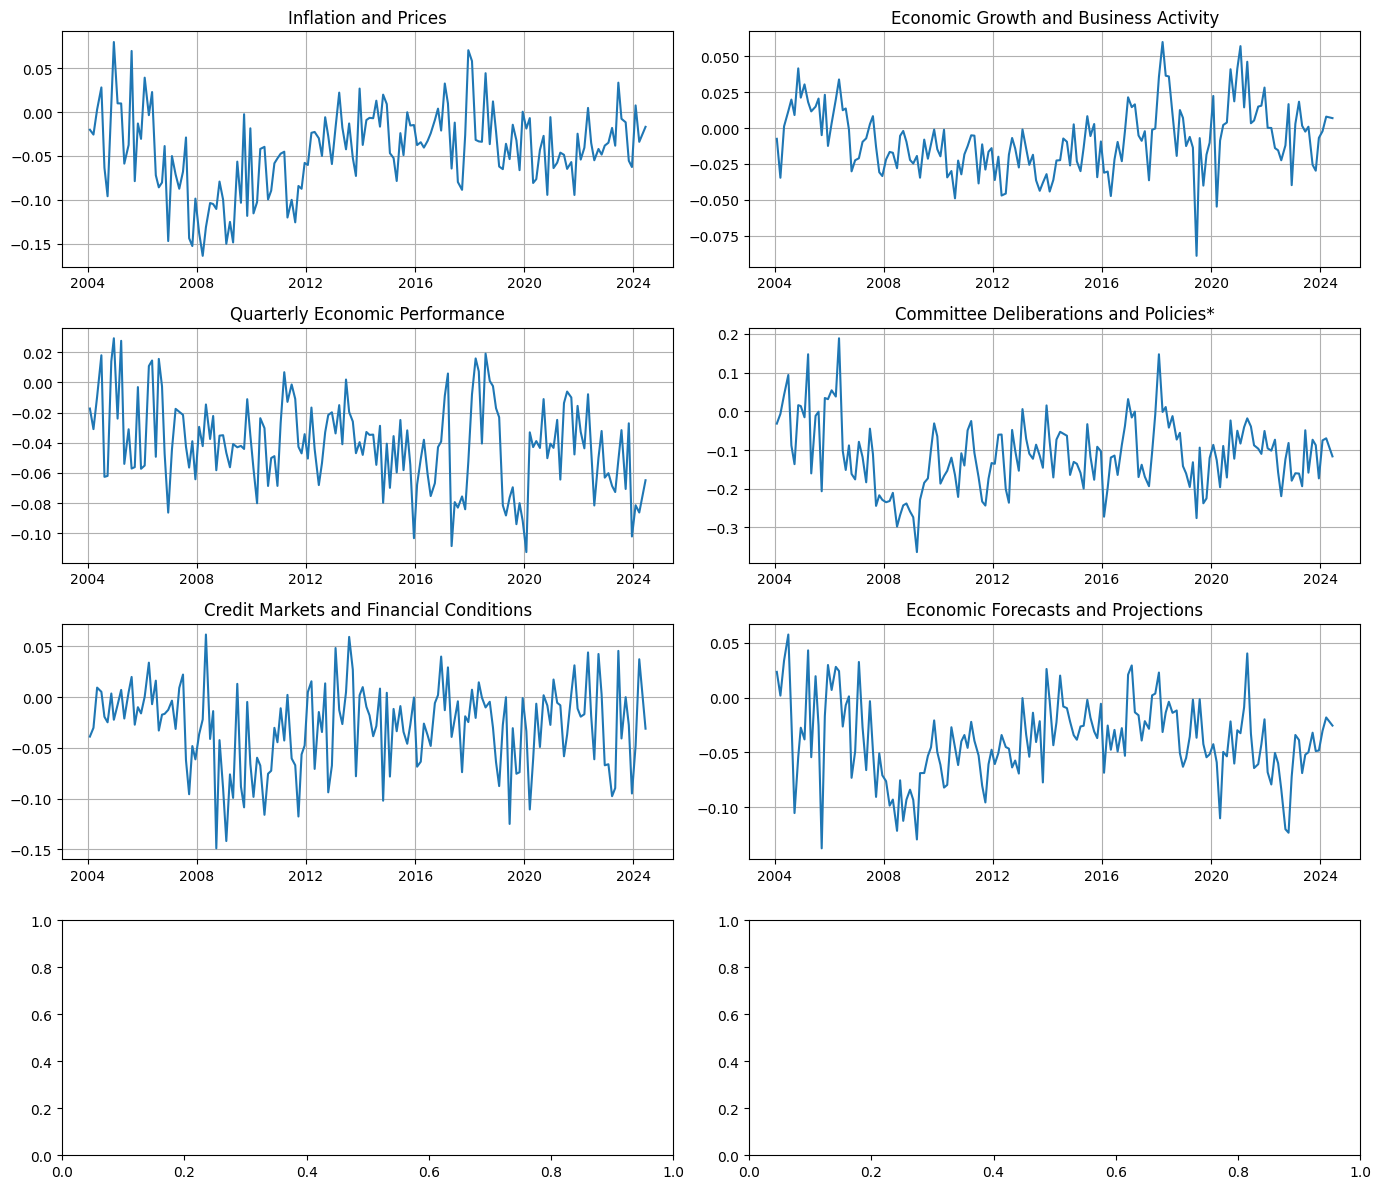

{'Inflation and Prices': (-2.3155219387763952, 0.1670106953463516, {'1%': -3.472703119504854, '5%': -2.880131672353732, '10%': -2.5766826861130268}), 'Economic Growth and Business Activity': (-3.237548148191653, 0.017911556873613756, {'1%': -3.472703119504854, '5%': -2.880131672353732, '10%': -2.5766826861130268}), 'Quarterly Economic Performance': (-3.824177766769118, 0.0026694089861143936, {'1%': -3.472703119504854, '5%': -2.880131672353732, '10%': -2.5766826861130268}), 'Committee Deliberations and Policies*': (-3.1393588912643544, 0.02377427788895954, {'1%': -3.472703119504854, '5%': -2.880131672353732, '10%': -2.5766826861130268}), 'Credit Markets and Financial Conditions': (-5.281489466783284, 5.980373460133115e-06, {'1%': -3.4718957209472654, '5%': -2.8797795410156253, '10%': -2.5764947265625}), 'Economic Forecasts and Projections': (-2.8093745339693226, 0.0569471097328402, {'1%': -3.474120870218417, '5%': -2.880749791423677, '10%': -2.5770126333102494})}
{'Inflation and Prices'

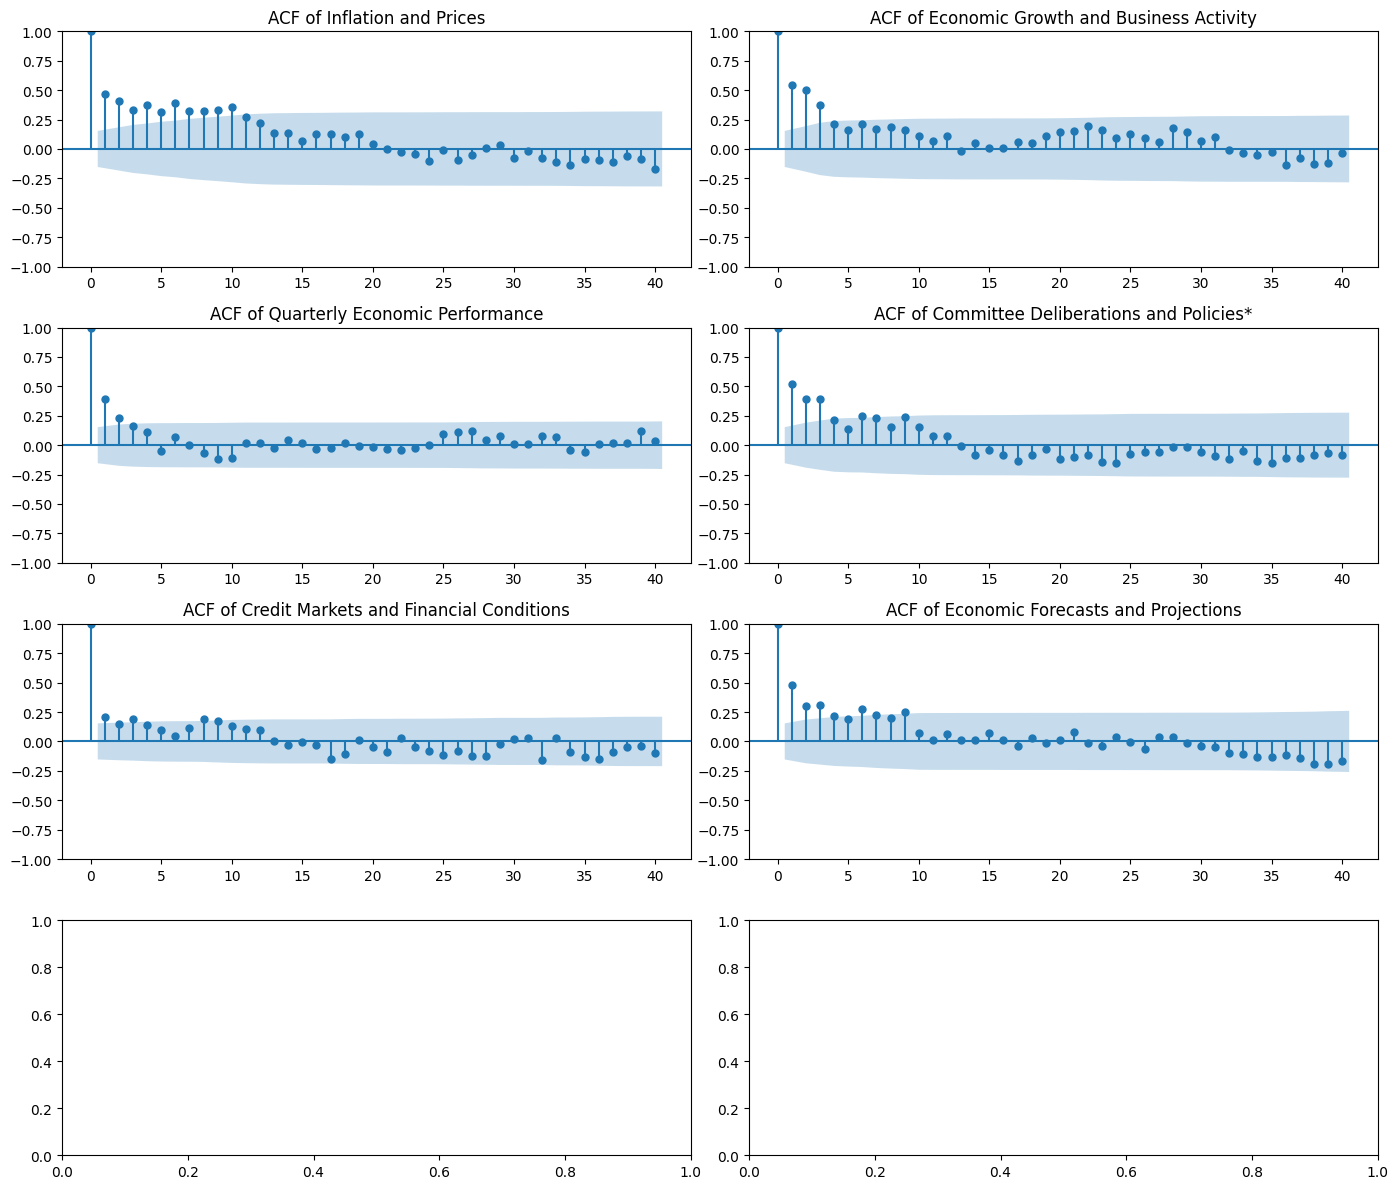

{'Inflation and Prices': [0.1689, 0.3284, 0.5106, 0.5809], 'Economic Growth and Business Activity': [0.5422, 0.3349, 0.5951, 0.482], 'Quarterly Economic Performance': [0.1863, 0.3443, 0.4361, 0.5589], 'Committee Deliberations and Policies*': [0.17, 0.0609, 0.0928, 0.1438], 'Credit Markets and Financial Conditions': [0.0434, 0.1156, 0.1924, 0.2969], 'Economic Forecasts and Projections': [0.9096, 0.8277, 0.9411, 0.7676]}


In [108]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller, grangercausalitytests
from statsmodels.graphics.tsaplots import plot_acf

# Load the merged data
merged_data_file_path = 'Merged_Sentiment_VIX_Data.csv'
merged_data = pd.read_csv(merged_data_file_path)

# Convert 'date' to datetime format
merged_data['date'] = pd.to_datetime(merged_data['date'])

# Prepare figure for plotting
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(14, 12))
axes = axes.flatten()

# List of independent variables (topics)
independent_vars = [
    'Inflation and Prices', 'Economic Growth and Business Activity', 
    'Quarterly Economic Performance', 'Committee Deliberations and Policies*',
    'Credit Markets and Financial Conditions', 'Economic Forecasts and Projections'
]

# Dictionary to hold ADF test results
adf_results = {}

# Plotting and ADF test
for i, var in enumerate(independent_vars):
    # Plotting time series
    axes[i].plot(merged_data['date'], merged_data[var])
    axes[i].set_title(var)
    axes[i].grid(True)

    # ADF test
    adf_result = adfuller(merged_data[var].dropna())
    adf_results[var] = (adf_result[0], adf_result[1], adf_result[4])

plt.tight_layout()
plt.show()

# Display ADF test results
print(adf_results)

# Processing first differences for non-stationary variables and redoing ADF test
non_stationary_vars = [var for var in independent_vars if adf_results[var][1] > 0.05]
first_differences = {}
adf_results_first_diff = {}

for var in non_stationary_vars:
    # Calculating first difference
    first_diff = merged_data[var].diff().dropna()

    # Storing first differences for potential further analysis
    first_differences[var] = first_diff

    # ADF test on first difference
    adf_result_diff = adfuller(first_diff)
    adf_results_first_diff[var] = (adf_result_diff[0], adf_result_diff[1], adf_result_diff[4])

print(adf_results_first_diff)

# Plot ACF for all variables
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(14, 12))
axes = axes.flatten()

for i, var in enumerate(independent_vars):
    plot_acf(merged_data[var].dropna(), lags=40, ax=axes[i], title=f'ACF of {var}')

plt.tight_layout()
plt.show()

# Redefine the stationary and non-stationary variables based on the latest ADF results
stationary_vars = [var for var in independent_vars if adf_results[var][1] <= 0.05]
non_stationary_vars = [var for var in independent_vars if adf_results[var][1] > 0.05]

# Ensure all variables are prepared for Granger tests (use first differences for non-stationary)
corrected_vars_for_granger = {}
for var in stationary_vars:
    corrected_vars_for_granger[var] = merged_data[var].dropna()  # Stationary, use original
for var in non_stationary_vars:
    corrected_vars_for_granger[var] = merged_data[var].diff().dropna()  # Non-stationary, use first difference

# Running Granger causality tests using corrected data for all variables
granger_results_corrected = {}
for var in independent_vars:
    data_for_granger_test = pd.concat([merged_data['VIX'], corrected_vars_for_granger[var]], axis=1).dropna()
    granger_result = grangercausalitytests(data_for_granger_test, maxlag=4, verbose=False)
    # Extracting p-values for each lag
    p_values = [round(granger_result[i + 1][0]['ssr_chi2test'][1], 4) for i in range(4)]
    granger_results_corrected[var] = p_values

print(granger_results_corrected)


In [109]:
import pandas as pd
from pyprocessmacro import Process
import warnings
from itertools import combinations

warnings.filterwarnings("ignore", category=DeprecationWarning)

# Load the merged data
merged_data_file_path = 'Merged_Sentiment_VIX_Data.csv'
merged_data = pd.read_csv(merged_data_file_path)

# Convert 'date' to datetime format
merged_data['date'] = pd.to_datetime(merged_data['date'])

# List of independent variables (topics)
independent_vars = [
    'Inflation and Prices', 'Economic Growth and Business Activity', 
    'Quarterly Economic Performance', 'Committee Deliberations and Policies*',
    'Credit Markets and Financial Conditions', 'Economic Forecasts and Projections'
]

# Use the first differences for non-stationary variables
for var in independent_vars:
    if var in non_stationary_vars:
        merged_data[var] = merged_data[var].diff()

# Drop NA values introduced by differencing
merged_data.dropna(inplace=True)

# Define a function to run mediation analyses
def run_mediation_analysis(data, x, y, m):
    mediation_model = Process(data=data, model=4, x=x, y=y, m=[m])
    return mediation_model.summary()

# Running the analyses for each combination
combinations_list = list(combinations(independent_vars, 2))
analysis_results = {}

for combo in combinations_list:
    x_var, mediator = combo
    result = run_mediation_analysis(merged_data, x=x_var, y='VIX', m=mediator)
    analysis_results[f'Mediation: {x_var} as IV, {mediator} as mediator'] = result

# Displaying Results
for label, result in analysis_results.items():
    print(f"\n{label}")
    print(result)


Process successfully initialized.
Based on the Process Macro by Andrew F. Hayes, Ph.D. (www.afhayes.com)


****************************** SPECIFICATION ****************************

Model = 4

Variables:
    Cons = Cons
    x = Inflation and Prices
    y = VIX
    m1 = Economic Growth and Business Activity

Sample size:
162

Bootstrapping information for indirect effects:
Final number of bootstrap samples: 5000
Number of samples discarded due to convergence issues: 0

***************************** OUTCOME MODELS ****************************

Outcome = VIX 
OLS Regression Summary

     R²  Adj. R²     MSE      F  df1  df2  p-value
 0.0144  -0.0043 74.9563 1.1656    2  159   0.3144

Coefficients

                                         coeff      se       t      p     LLCI    ULCI
Cons                                   18.6005  0.7173 25.9312 0.0000  17.1946 20.0064
Inflation and Prices                   -7.1455 14.1654 -0.5044 0.6147 -34.9091 20.6181
Economic Growth and Business Activi

/Users/chandrajason/anaconda3/lib/python3.11/site-packages/pyprocessmacro/models.py:1222: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  return df.apply(pd.to_numeric, args=["ignore"])


Process successfully initialized.
Based on the Process Macro by Andrew F. Hayes, Ph.D. (www.afhayes.com)


****************************** SPECIFICATION ****************************

Model = 4

Variables:
    Cons = Cons
    x = Inflation and Prices
    y = VIX
    m1 = Quarterly Economic Performance

Sample size:
162

Bootstrapping information for indirect effects:
Final number of bootstrap samples: 5000
Number of samples discarded due to convergence issues: 0

***************************** OUTCOME MODELS ****************************

Outcome = VIX 
OLS Regression Summary

     R²  Adj. R²     MSE      F  df1  df2  p-value
 0.0049  -0.0140 75.6856 0.3882    2  159   0.6789

Coefficients

                                 coeff      se       t      p     LLCI    ULCI
Cons                           19.5736  1.1966 16.3573 0.0000  17.2283 21.9190
Inflation and Prices           -9.2578 14.2954 -0.6476 0.5182 -37.2764 18.7607
Quarterly Economic Performance 15.9785 24.0783  0.6636 0.5079 -31.

/Users/chandrajason/anaconda3/lib/python3.11/site-packages/pyprocessmacro/models.py:1222: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  return df.apply(pd.to_numeric, args=["ignore"])


Process successfully initialized.
Based on the Process Macro by Andrew F. Hayes, Ph.D. (www.afhayes.com)


****************************** SPECIFICATION ****************************

Model = 4

Variables:
    Cons = Cons
    x = Inflation and Prices
    y = VIX
    m1 = Committee Deliberations and Policies*

Sample size:
162

Bootstrapping information for indirect effects:
Final number of bootstrap samples: 5000
Number of samples discarded due to convergence issues: 0

***************************** OUTCOME MODELS ****************************

Outcome = VIX 
OLS Regression Summary

     R²  Adj. R²     MSE       F  df1  df2  p-value
 0.1588   0.1429 63.9751 15.0117    2  159   0.0000

Coefficients

                                         coeff      se       t      p     LLCI     ULCI
Cons                                   14.5004  1.0270 14.1189 0.0000  12.4875  16.5133
Inflation and Prices                   10.3525 13.5061  0.7665 0.4445 -16.1190  36.8240
Committee Deliberations and Po

/Users/chandrajason/anaconda3/lib/python3.11/site-packages/pyprocessmacro/models.py:1222: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  return df.apply(pd.to_numeric, args=["ignore"])


Process successfully initialized.
Based on the Process Macro by Andrew F. Hayes, Ph.D. (www.afhayes.com)


****************************** SPECIFICATION ****************************

Model = 4

Variables:
    Cons = Cons
    x = Inflation and Prices
    y = VIX
    m1 = Credit Markets and Financial Conditions

Sample size:
162

Bootstrapping information for indirect effects:
Final number of bootstrap samples: 5000
Number of samples discarded due to convergence issues: 0

***************************** OUTCOME MODELS ****************************

Outcome = VIX 
OLS Regression Summary

     R²  Adj. R²     MSE       F  df1  df2  p-value
 0.1368   0.1204 65.6515 12.5983    2  159   0.0000

Coefficients

                                           coeff      se       t      p      LLCI     ULCI
Cons                                     16.6450  0.7837 21.2385 0.0000   15.1089  18.1811
Inflation and Prices                     -0.6900 13.3237 -0.0518 0.9588  -26.8038  25.4239
Credit Markets and 

/Users/chandrajason/anaconda3/lib/python3.11/site-packages/pyprocessmacro/models.py:1222: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  return df.apply(pd.to_numeric, args=["ignore"])


Process successfully initialized.
Based on the Process Macro by Andrew F. Hayes, Ph.D. (www.afhayes.com)


****************************** SPECIFICATION ****************************

Model = 4

Variables:
    Cons = Cons
    x = Inflation and Prices
    y = VIX
    m1 = Economic Forecasts and Projections

Sample size:
162

Bootstrapping information for indirect effects:
Final number of bootstrap samples: 5000
Number of samples discarded due to convergence issues: 0

***************************** OUTCOME MODELS ****************************

Outcome = VIX 
OLS Regression Summary

     R²  Adj. R²     MSE      F  df1  df2  p-value
 0.0029  -0.0160 75.8339 0.2320    2  159   0.7932

Coefficients

                                     coeff      se       t      p     LLCI    ULCI
Cons                               18.9197  0.6842 27.6517 0.0000  17.5786 20.2607
Inflation and Prices               -6.5083 15.0235 -0.4332 0.6655 -35.9539 22.9373
Economic Forecasts and Projections -7.0913 19.7771

/Users/chandrajason/anaconda3/lib/python3.11/site-packages/pyprocessmacro/models.py:1222: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  return df.apply(pd.to_numeric, args=["ignore"])


Process successfully initialized.
Based on the Process Macro by Andrew F. Hayes, Ph.D. (www.afhayes.com)


****************************** SPECIFICATION ****************************

Model = 4

Variables:
    Cons = Cons
    x = Economic Growth and Business Activity
    y = VIX
    m1 = Quarterly Economic Performance

Sample size:
162

Bootstrapping information for indirect effects:
Final number of bootstrap samples: 5000
Number of samples discarded due to convergence issues: 0

***************************** OUTCOME MODELS ****************************

Outcome = VIX 
OLS Regression Summary

     R²  Adj. R²     MSE      F  df1  df2  p-value
 0.0202   0.0015 74.5225 1.6351    2  159   0.1982

Coefficients

                                         coeff      se       t      p      LLCI    ULCI
Cons                                   19.6207  1.1847 16.5618 0.0000   17.2987 21.9426
Economic Growth and Business Activity -52.5522 30.8197 -1.7051 0.0901 -112.9577  7.8534
Quarterly Economic Per

/Users/chandrajason/anaconda3/lib/python3.11/site-packages/pyprocessmacro/models.py:1222: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  return df.apply(pd.to_numeric, args=["ignore"])


Process successfully initialized.
Based on the Process Macro by Andrew F. Hayes, Ph.D. (www.afhayes.com)


****************************** SPECIFICATION ****************************

Model = 4

Variables:
    Cons = Cons
    x = Economic Growth and Business Activity
    y = VIX
    m1 = Committee Deliberations and Policies*

Sample size:
162

Bootstrapping information for indirect effects:
Final number of bootstrap samples: 5000
Number of samples discarded due to convergence issues: 0

***************************** OUTCOME MODELS ****************************

Outcome = VIX 
OLS Regression Summary

     R²  Adj. R²     MSE       F  df1  df2  p-value
 0.1686   0.1528 63.2330 16.1208    2  159   0.0000

Coefficients

                                         coeff      se       t      p     LLCI     ULCI
Cons                                   14.2765  1.0295 13.8673 0.0000  12.2587  16.2943
Economic Growth and Business Activity  50.1215 31.9546  1.5685 0.1187 -12.5084 112.7514
Committee Del

/Users/chandrajason/anaconda3/lib/python3.11/site-packages/pyprocessmacro/models.py:1222: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  return df.apply(pd.to_numeric, args=["ignore"])


Process successfully initialized.
Based on the Process Macro by Andrew F. Hayes, Ph.D. (www.afhayes.com)


****************************** SPECIFICATION ****************************

Model = 4

Variables:
    Cons = Cons
    x = Economic Growth and Business Activity
    y = VIX
    m1 = Credit Markets and Financial Conditions

Sample size:
162

Bootstrapping information for indirect effects:
Final number of bootstrap samples: 5000
Number of samples discarded due to convergence issues: 0

***************************** OUTCOME MODELS ****************************

Outcome = VIX 
OLS Regression Summary

     R²  Adj. R²     MSE       F  df1  df2  p-value
 0.1377   0.1214 65.5797 12.6991    2  159   0.0000

Coefficients

                                           coeff      se       t      p      LLCI     ULCI
Cons                                     16.6597  0.7826 21.2865 0.0000   15.1258  18.1937
Economic Growth and Business Activity    12.5568 29.8649  0.4205 0.6747  -45.9772  71.0909
Cr

/Users/chandrajason/anaconda3/lib/python3.11/site-packages/pyprocessmacro/models.py:1222: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  return df.apply(pd.to_numeric, args=["ignore"])


Process successfully initialized.
Based on the Process Macro by Andrew F. Hayes, Ph.D. (www.afhayes.com)


****************************** SPECIFICATION ****************************

Model = 4

Variables:
    Cons = Cons
    x = Economic Growth and Business Activity
    y = VIX
    m1 = Economic Forecasts and Projections

Sample size:
162

Bootstrapping information for indirect effects:
Final number of bootstrap samples: 5000
Number of samples discarded due to convergence issues: 0

***************************** OUTCOME MODELS ****************************

Outcome = VIX 
OLS Regression Summary

     R²  Adj. R²     MSE      F  df1  df2  p-value
 0.0138  -0.0050 75.0077 1.1102    2  159   0.3320

Coefficients

                                         coeff      se       t      p     LLCI    ULCI
Cons                                   18.6010  0.7177 25.9188 0.0000  17.1944 20.0076
Economic Growth and Business Activity -41.3096 29.6501 -1.3932 0.1655 -99.4228 16.8036
Economic Forecasts an

/Users/chandrajason/anaconda3/lib/python3.11/site-packages/pyprocessmacro/models.py:1222: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  return df.apply(pd.to_numeric, args=["ignore"])


Process successfully initialized.
Based on the Process Macro by Andrew F. Hayes, Ph.D. (www.afhayes.com)


****************************** SPECIFICATION ****************************

Model = 4

Variables:
    Cons = Cons
    x = Quarterly Economic Performance
    y = VIX
    m1 = Committee Deliberations and Policies*

Sample size:
162

Bootstrapping information for indirect effects:
Final number of bootstrap samples: 5000
Number of samples discarded due to convergence issues: 0

***************************** OUTCOME MODELS ****************************

Outcome = VIX 
OLS Regression Summary

     R²  Adj. R²     MSE       F  df1  df2  p-value
 0.2234   0.2086 59.0667 22.8655    2  159   0.0000

Coefficients

                                         coeff      se       t      p     LLCI     ULCI
Cons                                   16.8102  1.1266 14.9213 0.0000  14.6021  19.0182
Quarterly Economic Performance         88.8463 23.8742  3.7214 0.0003  42.0537 135.6388
Committee Deliberati

/Users/chandrajason/anaconda3/lib/python3.11/site-packages/pyprocessmacro/models.py:1222: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  return df.apply(pd.to_numeric, args=["ignore"])


Process successfully initialized.
Based on the Process Macro by Andrew F. Hayes, Ph.D. (www.afhayes.com)


****************************** SPECIFICATION ****************************

Model = 4

Variables:
    Cons = Cons
    x = Quarterly Economic Performance
    y = VIX
    m1 = Credit Markets and Financial Conditions

Sample size:
162

Bootstrapping information for indirect effects:
Final number of bootstrap samples: 5000
Number of samples discarded due to convergence issues: 0

***************************** OUTCOME MODELS ****************************

Outcome = VIX 
OLS Regression Summary

     R²  Adj. R²     MSE       F  df1  df2  p-value
 0.1615   0.1455 63.7756 15.3073    2  159   0.0000

Coefficients

                                           coeff      se       t      p      LLCI     ULCI
Cons                                     18.3798  1.1132 16.5114 0.0000   16.1980  20.5615
Quarterly Economic Performance           49.5180 22.8904  2.1633 0.0320    4.6536  94.3825
Credit Ma

/Users/chandrajason/anaconda3/lib/python3.11/site-packages/pyprocessmacro/models.py:1222: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  return df.apply(pd.to_numeric, args=["ignore"])


Process successfully initialized.
Based on the Process Macro by Andrew F. Hayes, Ph.D. (www.afhayes.com)


****************************** SPECIFICATION ****************************

Model = 4

Variables:
    Cons = Cons
    x = Quarterly Economic Performance
    y = VIX
    m1 = Economic Forecasts and Projections

Sample size:
162

Bootstrapping information for indirect effects:
Final number of bootstrap samples: 5000
Number of samples discarded due to convergence issues: 0

***************************** OUTCOME MODELS ****************************

Outcome = VIX 
OLS Regression Summary

     R²  Adj. R²     MSE      F  df1  df2  p-value
 0.0046  -0.0143 75.7044 0.3684    2  159   0.6924

Coefficients

                                      coeff      se       t      p     LLCI    ULCI
Cons                                19.5872  1.1995 16.3294 0.0000  17.2362 21.9382
Quarterly Economic Performance      16.4024 24.1829  0.6783 0.4986 -30.9951 63.8000
Economic Forecasts and Projections -1

/Users/chandrajason/anaconda3/lib/python3.11/site-packages/pyprocessmacro/models.py:1222: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  return df.apply(pd.to_numeric, args=["ignore"])


Process successfully initialized.
Based on the Process Macro by Andrew F. Hayes, Ph.D. (www.afhayes.com)


****************************** SPECIFICATION ****************************

Model = 4

Variables:
    Cons = Cons
    x = Committee Deliberations and Policies*
    y = VIX
    m1 = Credit Markets and Financial Conditions

Sample size:
162

Bootstrapping information for indirect effects:
Final number of bootstrap samples: 5000
Number of samples discarded due to convergence issues: 0

***************************** OUTCOME MODELS ****************************

Outcome = VIX 
OLS Regression Summary

     R²  Adj. R²     MSE       F  df1  df2  p-value
 0.1891   0.1737 61.6725 18.5404    2  159   0.0000

Coefficients

                                           coeff      se       t      p     LLCI     ULCI
Cons                                     14.6114  0.9881 14.7873 0.0000  12.6748  16.5481
Committee Deliberations and Policies*   -26.3333  8.2206 -3.2033 0.0016 -42.4454 -10.2213
Credi

/Users/chandrajason/anaconda3/lib/python3.11/site-packages/pyprocessmacro/models.py:1222: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  return df.apply(pd.to_numeric, args=["ignore"])


Process successfully initialized.
Based on the Process Macro by Andrew F. Hayes, Ph.D. (www.afhayes.com)


****************************** SPECIFICATION ****************************

Model = 4

Variables:
    Cons = Cons
    x = Committee Deliberations and Policies*
    y = VIX
    m1 = Economic Forecasts and Projections

Sample size:
162

Bootstrapping information for indirect effects:
Final number of bootstrap samples: 5000
Number of samples discarded due to convergence issues: 0

***************************** OUTCOME MODELS ****************************

Outcome = VIX 
OLS Regression Summary

     R²  Adj. R²     MSE       F  df1  df2  p-value
 0.1646   0.1487 63.5390 15.6604    2  159   0.0000

Coefficients

                                         coeff      se       t      p     LLCI     ULCI
Cons                                   14.3096  1.0381 13.7839 0.0000  12.2749  16.3443
Committee Deliberations and Policies* -41.0789  7.3791 -5.5670 0.0000 -55.5416 -26.6162
Economic Forecas

/Users/chandrajason/anaconda3/lib/python3.11/site-packages/pyprocessmacro/models.py:1222: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  return df.apply(pd.to_numeric, args=["ignore"])


Process successfully initialized.
Based on the Process Macro by Andrew F. Hayes, Ph.D. (www.afhayes.com)


****************************** SPECIFICATION ****************************

Model = 4

Variables:
    Cons = Cons
    x = Credit Markets and Financial Conditions
    y = VIX
    m1 = Economic Forecasts and Projections

Sample size:
162

Bootstrapping information for indirect effects:
Final number of bootstrap samples: 5000
Number of samples discarded due to convergence issues: 0

***************************** OUTCOME MODELS ****************************

Outcome = VIX 
OLS Regression Summary

     R²  Adj. R²     MSE       F  df1  df2  p-value
 0.1379   0.1215 65.5664 12.7179    2  159   0.0000

Coefficients

                                           coeff      se       t      p      LLCI     ULCI
Cons                                     16.6020  0.7864 21.1110 0.0000   15.0607  18.1433
Credit Markets and Financial Conditions -79.7941 15.9219 -5.0116 0.0000 -111.0004 -48.5879
Econo

/Users/chandrajason/anaconda3/lib/python3.11/site-packages/pyprocessmacro/models.py:1222: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  return df.apply(pd.to_numeric, args=["ignore"])
